In [27]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta


curr_dir = sys.path[0]
utils_dir = os.path.join(curr_dir.split("EIA_grid")[0], "utils")
if utils_dir not in sys.path:
    sys.path.append(utils_dir)
from util_func import get_dataset_dir
from plot_utils import customize_plt
customize_plt()

from dl_eia_grid import get_latest_fn

use_sample = True   # you can use the sample file of [Region_CAL] if you haven't downloaded the full dataset
eia_grid_dir = get_dataset_dir("eia_grid") if not use_sample else "sample"

In [4]:
region_url_df = pd.read_excel("EIA_region_url.xlsx")
avail_names = [url.split("/")[-1][:-5] for url in region_url_df["URL"].tolist()]
for i in range(len(avail_names)):
    name = avail_names[i]
    print(f"{name:<15}", end="")
    if i % 8 == 7:
        print()

Region_CAL     Region_CAR     Region_CENT    Region_FLA     Region_MIDA    Region_MIDW    Region_NE      Region_NY      
Region_NW      Region_SE      Region_SW      Region_TEN     Region_TEX     Region_US48    YAD            AZPS           
DEAA           AECI           AVRN           AVA            BANC           BPAT           CISO           HST            
TPWR           TAL            SCEG           DUK            FPC            CPLE           CPLW           EPE            
EEI            ERCO           FMPP           FPL            GVL            GRMA           GLHB           GRID           
GRIF           ISNE           IPCO           IID            JEA            LDWP           LGEE           MISO           
GWA            WWA            NEVP           HGMA           NYIS           NWMT           OVEC           PJM            
DOPD           PACE           PACW           PGE            AEC            PSCO           PNM            CHPD           
GCPD           PSEI           SR

## load data

In [28]:
region = "Region_CAL"
fn, *_ = get_latest_fn(region, os.listdir(eia_grid_dir))
fn = os.path.join(eia_grid_dir, fn)
dfs = pd.read_excel(fn, sheet_name=["Published Hourly Data", "Published Daily Data"])
hourly_df = dfs["Published Hourly Data"]
daily_df = dfs["Published Daily Data"]

# hourly data analysis

In [6]:
var_datetime = ["UTC time", "Local time"]
for var in var_datetime:
    hourly_df[var] = pd.to_datetime(hourly_df[var])
hourly_df.head()

,Region,UTC time,Local date,Hour,Local time,Time zone,DF,D,NG,TI,...,CO2 Emissions: OIL,CO2 Emissions: Other,CO2 Emissions Generated,CO2 Emissions Imported,CO2 Emissions Exported,CO2 Emissions Consumed,Positive Generation,Consumed Electricity,CO2 Emissions Intensity for Generated Electricity,CO2 Emissions Intensity for Consumed Electricity
0,CAL,2015-07-01 08:00:00,2015-07-01,1,2015-07-01 01:00:00,Pacific,35264,38210.0,31005.0,-7412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CAL,2015-07-01 09:00:00,2015-07-01,2,2015-07-01 02:00:00,Pacific,32894,35171.0,28760.0,-6671.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CAL,2015-07-01 10:00:00,2015-07-01,3,2015-07-01 03:00:00,Pacific,31360,33243.0,27179.0,-6306.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CAL,2015-07-01 11:00:00,2015-07-01,4,2015-07-01 04:00:00,Pacific,30579,31955.0,25660.0,-6551.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CAL,2015-07-01 12:00:00,2015-07-01,5,2015-07-01 05:00:00,Pacific,30723,31199.0,24961.0,-6491.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### visualize data availability (non-NAs)

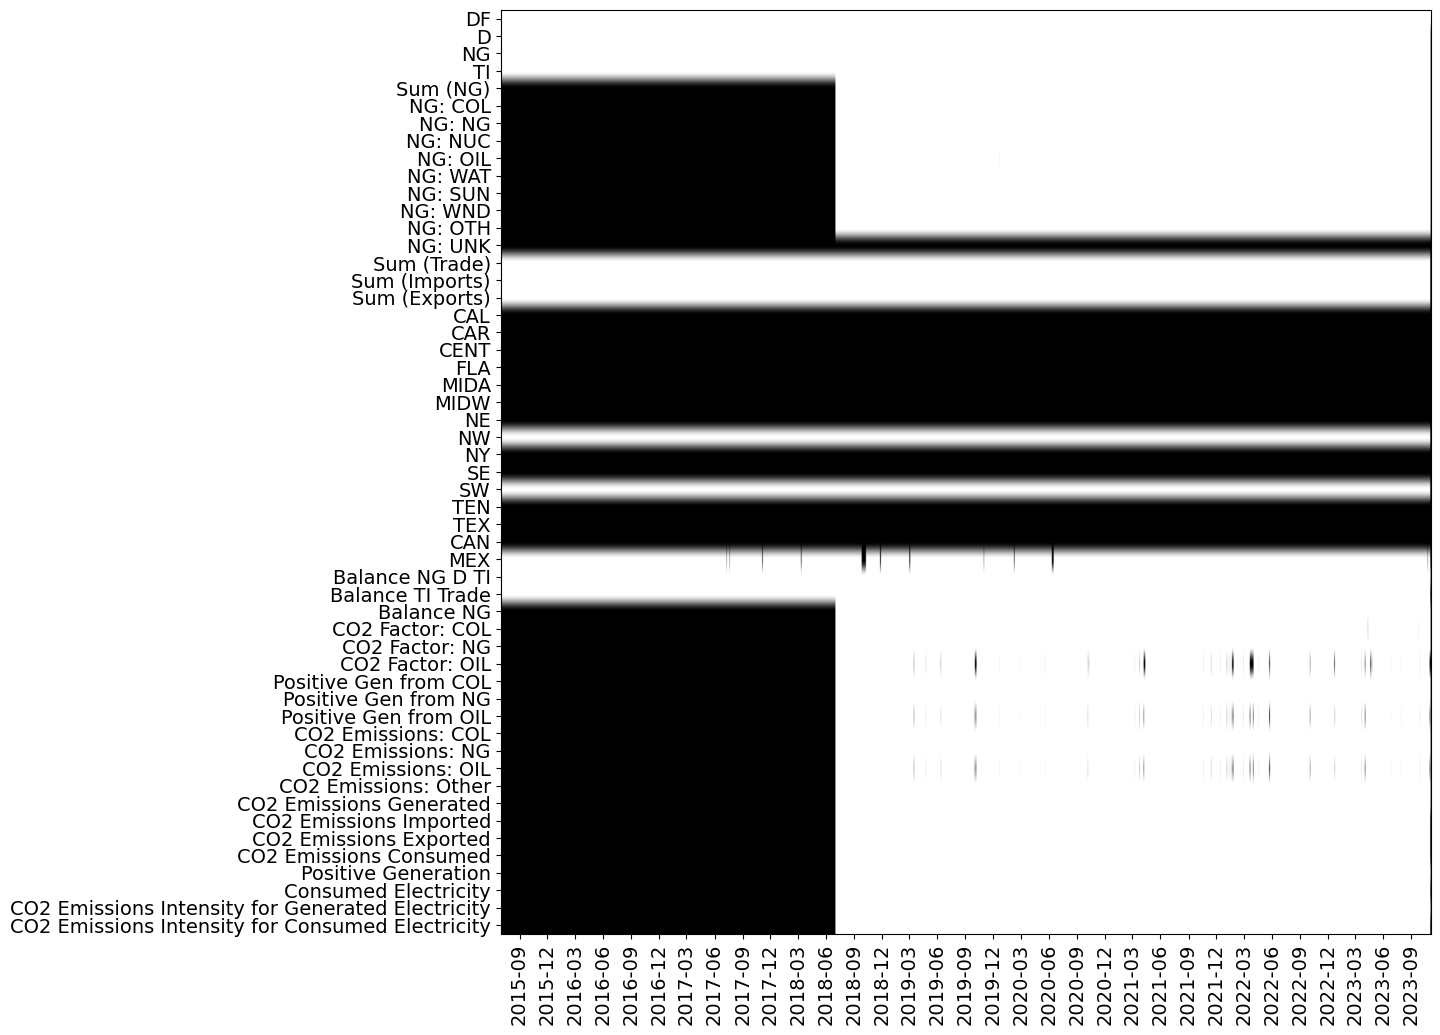

In [29]:
cols = hourly_df.columns[6:] # 6 is the first column of data (before are region/datetime)
na_matrix = pd.isna(hourly_df[cols])

# get indices of 1st day of every month
month_first_hr = hourly_df["Local time"].apply(lambda x: x.day==1 and x.hour==0)
idx_month_first_hr = np.where(month_first_hr)[0]
month_names = hourly_df.loc[idx_month_first_hr, "Local time"].apply(lambda x: x.strftime("%Y-%m")).tolist()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(na_matrix.T, aspect="auto", cmap="gray_r")
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(cols)
ax.set_xticks(idx_month_first_hr[1::3])
_ = ax.set_xticklabels(month_names[1::3], rotation=90)


### Hourly Data Panel

In [23]:
def add_xticks(df, ax):
    xticks = df["Local time"].\
        loc[df["Local time"].apply(lambda x: x.hour==1)]
    xticklabels = xticks.apply(lambda x: f"{x.strftime('%m-%d')}")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=45, fontsize=10)
    # TODO: add year before the first tick
    # TODO: use shadow to show daytime (6 AM - 6 PM)

def hourly_panel1(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.plot(df["Local time"], df["D"], color="dodgerblue", label="Demand")
    ax.plot(df["Local time"], df["DF"], color="dodgerblue", ls="dotted", label="Forecast demand")
    ax.plot(df["Local time"], df["NG"], color="gold", label="Net generation")
    ax.plot(df["Local time"], df["TI"], color="seagreen", label="Total interchange")

    add_xticks(df, ax)
    ax.set_ylabel("MWh")
    ax.set_title(f"{region.replace('_', ' ')}\nHourly electricity demand, net generation, and total interchange", fontweight="bold")
    ax.legend(loc=(1.02,0.2), labelspacing=2)

def hourly_panel2(df, ax=None):
    if ax is None:
        ax = plt.gca()
    sources = {
        'NG: COL': ("Coal", "saddlebrown"),
        'NG: NG': ("Natural gas", "lightsalmon"),
        'NG: NUC': ("Nuclear", "firebrick"),
        'NG: OIL': ("Petroleum", "purple"),
        'NG: WAT': ("Hydro", "dodgerblue"),
        'NG: SUN': ("Solar", "gold"),
        'NG: WND': ("Wind", "seagreen"),
        'NG: OTH': ("Other", "gray"),
        'NG: UNK': ("Unknown", "lightcoral")
    }

    for source, (name, color) in sources.items():
        ax.plot(df["Local time"], df[source], color=color, label=name)
    
    ax.plot(df["Local time"], df["NG"], color="k", ls="dashed", label="Net generation")

    add_xticks(df, ax)
    ax.set_ylabel("MWh")
    ax.set_title("Hourly electricity net generation by energy source", fontweight="bold")
    ax.legend(loc=(1.02,-0.05), labelspacing=1)

def hourly_panel3(df, ax=None):
    if ax is None:
        ax = plt.gca()
    sources = {
        'CO2 Emissions: COL': ("Coal", "saddlebrown"),
        'CO2 Emissions: NG': ("Natural gas", "lightsalmon"),
        'CO2 Emissions: OIL': ("Petroleum", "purple"),
        'CO2 Emissions: Other': ("Other", "gray"),
        'CO2 Emissions Imported': ("Imports", "gold"),
        'CO2 Emissions Exported': ("Exports", "goldenrod")
    }

    for source, (name, color) in sources.items():
        ax.plot(df["Local time"], df[source], color=color, label=name)
    
    add_xticks(df, ax)
    ax.set_ylabel("Thousand Tons")
    ax.set_title("Hourly CO2 emissions by energy source", fontweight="bold")
    ax.legend(loc=(1.02, 0.15), labelspacing=1.5)

def hourly_panel4(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    c1 = "saddlebrown"
    ax.plot(df["Local time"], df["CO2 Emissions Generated"], color=c1, label="CO2 (generated)")
    ax.plot(df["Local time"], df["CO2 Emissions Consumed"], color=c1, ls="dotted", label="CO2 (Consumed)")
    ax.set_ylabel("CO2 Emissions (Thousand Tons)", color=c1)
    ax.tick_params(axis='y', labelcolor=c1)

    ax2 = ax.twinx()
    c2 = "navy"
    ax2.plot(df["Local time"], df["CO2 Emissions Intensity for Generated Electricity"], color=c2, label="Intensity (Generated)")
    ax2.plot(df["Local time"], df["CO2 Emissions Intensity for Consumed Electricity"], color=c2, ls="dotted", label="Intensity (Consumed)")
    ax2.set_ylabel("CO2 Emission Intensity (lb/kWh)", color=c2)
    ax2.tick_params(axis='y', labelcolor=c2)
    
    add_xticks(df, ax)
    ax.legend(loc=(1.1, 0.2), labelspacing=1.5)
    ax2.legend(loc=(1.1, 0.5), labelspacing=1.5)
    
    ax.set_title("Hourly CO2 emissions intensity", fontweight="bold")


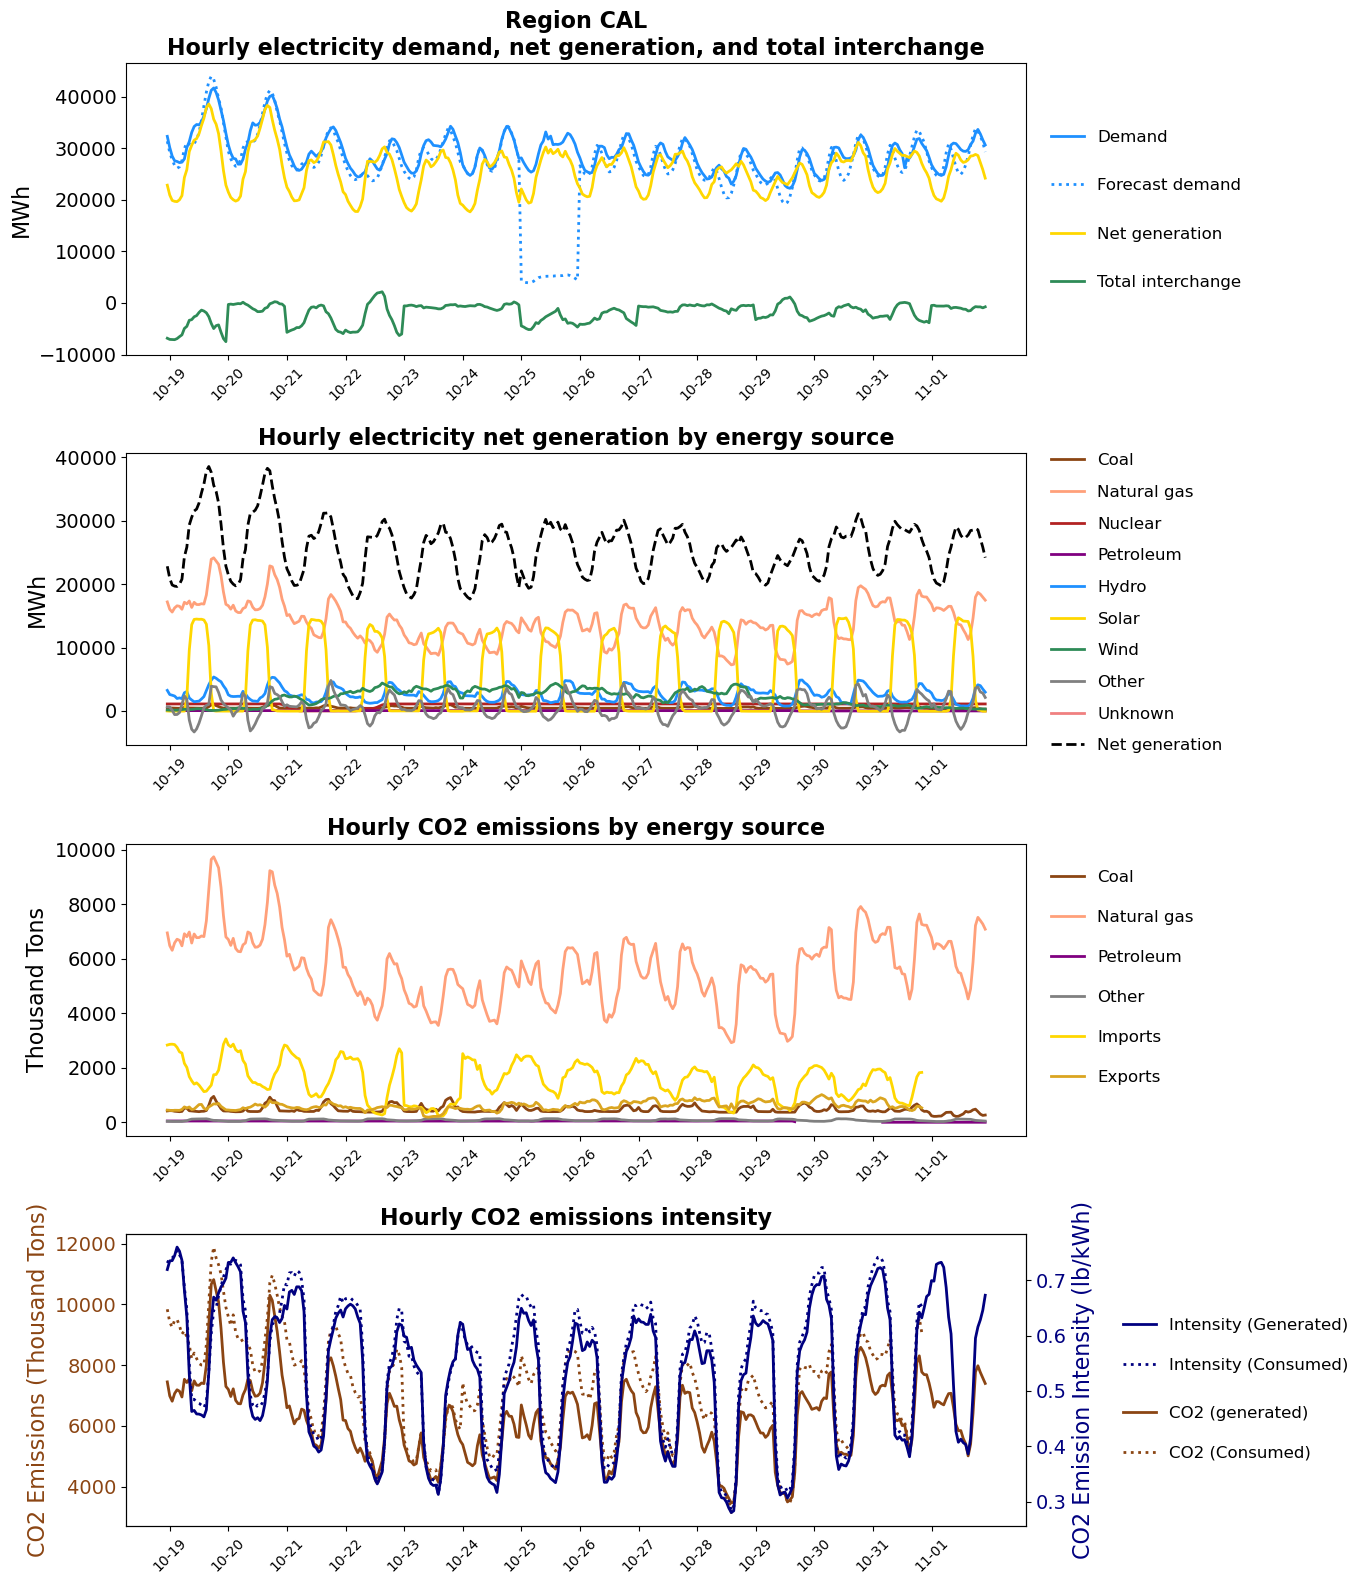

In [24]:
date = "2023-11-01"
days = 14

start = datetime.strptime(date, "%Y-%m-%d")-timedelta(days=days-1)
end = start+timedelta(days=days)
hourly_sub_df = hourly_df[(hourly_df["Local time"]>=start) & (hourly_df["Local time"]<end)]


fig, axs = plt.subplots(4, 1, figsize=(14, 16))
hourly_panel1(hourly_sub_df, axs[0])
hourly_panel2(hourly_sub_df, axs[1])
hourly_panel3(hourly_sub_df, axs[2])
hourly_panel4(hourly_sub_df, axs[3])
plt.tight_layout()

## Daily data analysis
Work in progress ...

In [30]:
daily_df.head()

,Region,Local date,Time zone,DF,D,NG,TI,Sum (NG),NG: COL,NG: NG,...,CO2 Emissions: OIL,CO2 Emissions: Other,CO2 Emissions Generated,CO2 Emissions Imported,CO2 Emissions Exported,CO2 Emissions Consumed,Positive Generation,Consumed Electricity,CO2 Emissions Intensity for Generated Electricity,CO2 Emissions Intensity for Consumed Electricity
0,CAL,2015-07-01,Pacific,1041650,978699.0,828278.0,-151682.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CAL,2015-07-02,Pacific,995338,962751.0,823180.0,-139485.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CAL,2015-07-03,Pacific,893938,887079.0,722091.0,-165219.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CAL,2015-07-04,Pacific,833410,830874.0,655779.0,-175339.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CAL,2015-07-05,Pacific,810977,791310.0,620598.0,-170970.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
